In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Set the path to the directory containing your MATLAB files
path = '/content/drive/My Drive/Colab Notebooks/neural data/'

# List all files in the directory to verify
print("Files in directory:", os.listdir(path))


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import scipy.io
import os

# Set the path to the directory containing your MATLAB files
path = '/content/drive/My Drive/Colab Notebooks/neural data/'

# Load the MATLAB files
cellName = 'T9C3'
formatSpec = os.path.join(path, f'BEN_{cellName}.mat')
pos_data_path = os.path.join(path, 'BEN_pos.mat')

try:
    data = scipy.io.loadmat(formatSpec)
    pos_data = scipy.io.loadmat(pos_data_path)
    print("Files loaded successfully.")

    # Example of accessing data:
    print("Keys in data:", data.keys())
    print("Keys in pos_data:", pos_data.keys())

except Exception as e:
    print("Failed to load files:", e)



Files loaded successfully.
Keys in data: dict_keys(['__header__', '__version__', '__globals__', 'cellTS'])
Keys in pos_data: dict_keys(['__header__', '__version__', '__globals__', 'recSystem', 'posx', 'posy', 'post', 'posx2', 'posy2'])


In [ ]:
import numpy as np
import scipy.io
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.special import factorial
import os

# Define the full path to the directory containing your MATLAB files
path = '/content/drive/My Drive/Colab Notebooks/neural data/'

# Load the MATLAB files with full paths
cellName = 'T9C3'
formatSpec = os.path.join(path, f'BEN_{cellName}.mat')
pos_data_path = os.path.join(path, 'BEN_pos.mat')

try:
    data = scipy.io.loadmat(formatSpec)
    pos_data = scipy.io.loadmat(pos_data_path)

    # Extract data from structures as needed, e.g.,
    post = pos_data['post'].flatten()
    posx = pos_data['posx'].flatten()
    posy = pos_data['posy'].flatten()
    cellTS = data['cellTS'].flatten()

    # Filter spikes beyond the last recorded location time
    cellTS = cellTS[cellTS < np.max(post)]

    # Interpolation setup
    dt = 0.4
    time = np.arange(np.min(post), np.max(post), dt)
    interp_x = interp1d(post, posx, kind='linear', fill_value='extrapolate')
    interp_y = interp1d(post, posy, kind='linear', fill_value='extrapolate')

    x_ = interp_x(time)
    y_ = interp_y(time)

    # Normalization
    x_ = (x_ - np.min(x_)) / (np.max(x_) - np.min(x_))
    y_ = (y_ - np.min(y_)) / (np.max(y_) - np.min(y_))

    # Discretize
    n = 50
    x = np.ceil(x_ * n).astype(int)
    y = np.ceil(y_ * n).astype(int)
    x = np.clip(x, 1, n) - 1
    y = np.clip(y, 1, n) - 1

    # Time bins for spikes
    T = len(time)
    spike_bins = np.ceil((dt + cellTS - np.min(post)) / dt).astype(int)
    spike_bins = np.clip(spike_bins, 1, T)

    # Spike count per time bin
    r = np.zeros(T)
    for l in spike_bins - 1:
        r[l] += 1

    # Calculation for mean_log_fac
    mean_log_fac = np.mean(np.log(factorial(r)))

    # Output a variable to check
    print("Mean of log of factorial of r:", mean_log_fac)


except Exception as e:
    print("Failed to load files:", e)


Mean of log of factorial of r: 1.249775676154541


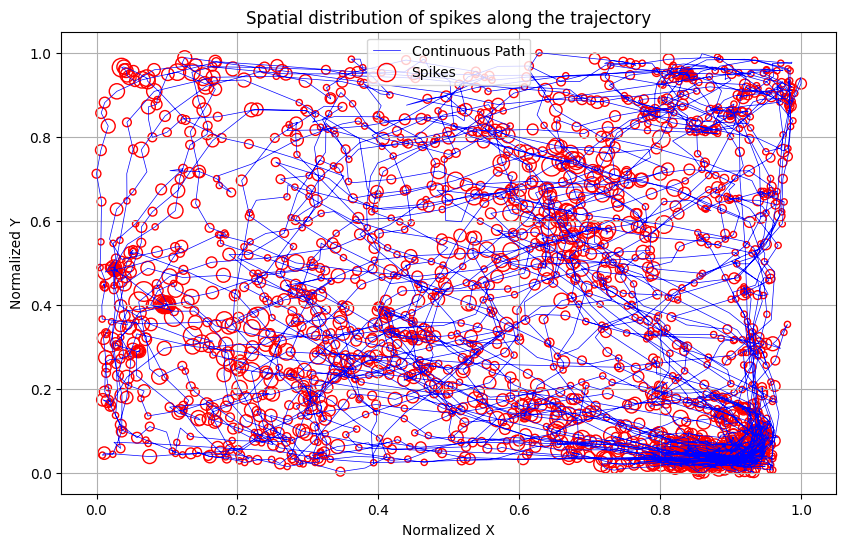

In [ ]:
import matplotlib.pyplot as plt

# Assuming previous code blocks have been executed and variables are defined
try:

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the continuous path with a thinner blue line
    plt.plot(x_, y_, 'b-', label='Continuous Path', linewidth=0.5)  # Thinner blue line

    # Add red circles for spikes
    spike_indices = np.where(r > 0)[0]
    # Scale the sizes of the circles based on the spike counts, multiplying by a factor for visibility
    sizes = r[spike_indices] * 20  # Scale factor can be adjusted as needed
    plt.scatter(x_[spike_indices], y_[spike_indices], facecolors='none', edgecolors='r', s=sizes, label='Spikes')

    # Adding labels and legend
    plt.title('Spatial distribution of spikes along the trajectory')
    plt.xlabel('Normalized X')
    plt.ylabel('Normalized Y')
    plt.legend()
    plt.grid(True)  # Adds a grid for easier visualization
    plt.show()

except Exception as e:
    print("Failed to plot due to:", e)


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# Assuming initialization of T, n, x, y, r
I    =   np.zeros(T, dtype=int)
R    =   np.zeros((n, n))
rows =   []
cols =   []
data =   []

# Calculate indices and update R
for t in range(T):
    I[t] = x[t] * n + n - 1 - y[t]
    R[n - y[t] - 1, x[t]] += r[t]
    rows.append(t)
    cols.append(I[t])
    data.append(1)  # You're setting this to 1, adjust if different values are needed


# Create the sparse matrix from the collected data
X = csr_matrix((data, (rows, cols)), shape=(T, n * n))

# Efficient computation of X^T * X
XTX = X.transpose().dot(X)

#print(XTX)  # This will display the sparse matrix format


In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix


m = 2 * n * (n - 1)  # Total number of edges in an n x n grid

# Initialize D as a lil_matrix for incremental construction
D = lil_matrix((m, n**2))

current_row = 0

# Populate the matrix
for i in range(n):
    for j in range(n):
        index = i * n + j  # Current node index (row-major order)

        # Right neighbor
        if j < n - 1:
            right_index = index + 1
            D[current_row, index] = 1
            D[current_row, right_index] = -1
            current_row += 1

        # Down neighbor
        if i < n - 1:
            down_index = index + n
            D[current_row, index] = 1
            D[current_row, down_index] = -1
            current_row += 1

# Convert to csr_matrix for efficient operations
D = D.tocsr()

# Print the matrix to see its structure
#print(D_csr)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg, LinearOperator, inv
from time import time  # Make sure to import the time function
np.random.seed(0)  # Setting seed for reproducibility
# Tolerance and maximum iterations
tol = 1e-6
maxiter = 100000
lm = 20
n2 = n * n
# Assume X, D, r are defined, for example:
# X = csr_matrix(np.random.randn(n*n, n*n))  # Example, should be defined according to your problem
# D = csr_matrix(...)  # Defined as per your grid's adjacency structure
# r = np.random.randn(n*n)
# Scalar variable to define the size of other arrays

lambdas = np.logspace(0, 2, lm)[::-1] # Array of lambda values from 1 to 0.1 in descending order

# Define the matrix-vector product function outside the loop
def matvec(v, lambda_reg):
    return X.T @ (X @ v) + lambda_reg * (D.T @ (D @ v))

# Vectors of zeros
ALO       = []  # Creates a column vector of zeros of length m
ALO_fast  = []   # Same as above
TRAIN     = []  # Same as above
timeALO       = [] # Creates a column vector of zeros of length m
timeALO_fast  = []   # Same as above
timeTRAIN     = []  # Same as above





# Right-hand side of the equation
b = X.T @ r
# Compute sum(X.T), which is equivalent to summing each row of X
sum_X_T = np.sum(X.T, axis=1).A.flatten()  # Using .A to convert to dense array and flatten to make 1D

# Compute (b+0.5) / (sum(X.T) + 0.5)
z = (b + 0.5) / (sum_X_T + 0.5)
S = 250  # Number of iterations/samples
# Arrays to store results
b_s1 = np.zeros((n2, S))  # to store results of X.T @ e_s1
b_s2 = np.zeros((n2, S))  # to store results of D.T @ e_s2
u_s  = np.zeros((n2, S))
for s in range(S):
    # Sample e_s1, e_s2 from N(0, I)
    e_s1 = np.random.normal(0, 1, T)
    e_s2 = np.random.normal(0, 1, m)
    # Compute b_s1 and b_s2
    b_s1[:, s] = X.T @ e_s1  # Compute X^T @ e_s1
    b_s2[:, s] = D.T @ e_s2  # Compute D^T @ e_s2
    # Optional: Print out the results to check
    #print("b_s1 results:\n", b_s1)
    #print("b_s2 results:\n", b_s2)

# Loop over different lambda values
for lambda_reg in lambdas:
    # Define shape of A for the LinearOperator with the current lambda
    n2 = X.shape[1]
    A = LinearOperator((n2, n2), matvec=lambda v: matvec(v, lambda_reg))
    # Start timing - TRAIN
    tstart = time()
    # Solve for y using conjugate gradient
    z, exit_code = cg(A, b, x0=z, tol=tol, maxiter=maxiter)
    # End timing
    fit_time = time() - tstart
    timeTRAIN.append(fit_time)  # Store the fitting time
    mse = np.mean((r - (X @ z))**2)
    TRAIN.append(mse)

    # Start timing - ALO
    tstart = time()
    diag_inv = np.zeros((n2,1))
    for i in range(n2):
        # Create the i-th unit vector in sparse format
        e_i = csr_matrix((np.array([1]), ([i], [0])), shape=(n2,1))
        e_i = e_i.toarray().ravel()
        # Solve A x = e_i
        # Since e_i is a 1xN matrix, we need to flatten it to make it a proper vector
        ae, exit_code = cg(A, e_i, tol=tol, maxiter=maxiter)
        if exit_code == 0:
            # The i-th diagonal element of A^{-1} is the i-th element of ae
            diag_inv[i] = ae[i]
            e = A @ ae
            if (np.sum(abs(A @ ae- e_i)) > 0.001):
                print(np.sum(abs(A @ ae- e_i)))
        else:
            raise Exception(f"CG did not converge for the {i}-th unit vector")
    hh = np.zeros((T,1))
    for t in range(T):
        hh[t] = diag_inv[I[t]]
    # End timing
    alo_time = time() - tstart
    timeALO_fast.append(alo_time)  # Store the fitting time
    alo     = np.mean(((r - (X @ z) ) / (1 - hh)) **2)
    ALO.append(alo)

    # Start timing - fast ALO
    tstart = time()
    b_s = b_s1 +  np.sqrt(lambda_reg) * b_s2
    # Solve the system A x = b for each column of b_s
    for s in range(S):
        u_, info = cg(A, b_s[:, s], x0=u_s[:, s])
        if info == 0:
            u_s[:, s] = u_
        else:
            print(f"CG did not converge for column {s}")
    #XU = X @ u_s
    #Z =  (u_s @ u_s.T) / S
    # Step 1: Center the data
    means = np.mean(u_s, axis=1, keepdims=True)
    u_s_centered = u_s - means
    # Step 2: Compute the covariance matrix
    Z =  np.dot(u_s_centered, u_s_centered.T) / (S - 1)
    #for l in range(4):
     #   Z  = 2*Z - Z @ (A @ Z)
    diag_inv_ = Z.diagonal()
    Z  = (X @ Z) @ X.T
    hh_fast = np.diag(Z)

    #print(hh_fast)
    #np.var(XU, axis=1, ddof=1)  # ddof=1 uses (S-1) in the denominator
    # End timing
    alo_fast_time = time() - tstart
    timeALO_fast.append(alo_fast_time)  # Store the fitting time
    alo_fast     = np.mean(((r - (X @ z)) / (1 - hh_fast)) **2)
    ALO_fast.append(alo_fast)
    print(f"lambda = {lambda_reg:.2f}| alo={alo:.2f}| alo time ={alo_time:.0f}| alo_fast={alo_fast:.2f}| alo_fast time ={alo_fast_time:.0f}| mse={mse:.2f}| fit time = {fit_time:.2f}| h ={np.mean(hh):.2f}| max_err ={np.max(abs(diag_inv_ - diag_inv)):.2f}| mean_err ={np.mean(abs(diag_inv_ - diag_inv)):.2f}")


# Ensure all arrays are numpy arrays for easier handling
fit_times = np.array(timeTRAIN)
tt=np.mean(fit_times)


lambda = 100.00| alo=2.95| alo time =130| alo_fast=2.95| alo_fast time =8| mse=2.92| fit time = 0.23| h =0.01| max_err =0.02| mean_err =0.00
lambda = 78.48| alo=2.90| alo time =115| alo_fast=2.90| alo_fast time =6| mse=2.86| fit time = 0.05| h =0.01| max_err =0.02| mean_err =0.00
lambda = 61.58| alo=2.85| alo time =107| alo_fast=2.86| alo_fast time =6| mse=2.80| fit time = 0.03| h =0.01| max_err =0.03| mean_err =0.00
lambda = 48.33| alo=2.80| alo time =99| alo_fast=2.81| alo_fast time =5| mse=2.74| fit time = 0.04| h =0.01| max_err =0.04| mean_err =0.00
lambda = 37.93| alo=2.76| alo time =91| alo_fast=2.76| alo_fast time =5| mse=2.68| fit time = 0.02| h =0.01| max_err =0.04| mean_err =0.00
lambda = 29.76| alo=2.71| alo time =81| alo_fast=2.71| alo_fast time =4| mse=2.62| fit time = 0.02| h =0.02| max_err =0.05| mean_err =0.00
lambda = 23.36| alo=2.67| alo time =77| alo_fast=2.67| alo_fast time =6| mse=2.56| fit time = 0.02| h =0.02| max_err =0.07| mean_err =0.01
lambda = 18.33| alo=2.6

In [ ]:
print(hh.shape[0])
print(hh_fast.shape[0])
print(T)
print(m)
print(X.shape[0])
print(X.shape[1])
print(D.shape[0])
print(D.shape[1])
print(Z.shape[1])
print(Z.shape[0])
C=(u_s @ u_s.T) / S
print(S)
#print( np.sum(abs(A @ ae- e_i.toarray().ravel())))

print(I)


3133
3133
3133
4900
3133
2500
4900
2500
3133
3133
5000
[1826 1776 1827 ... 2347 2347 2347]


0.0
893.9341819286346


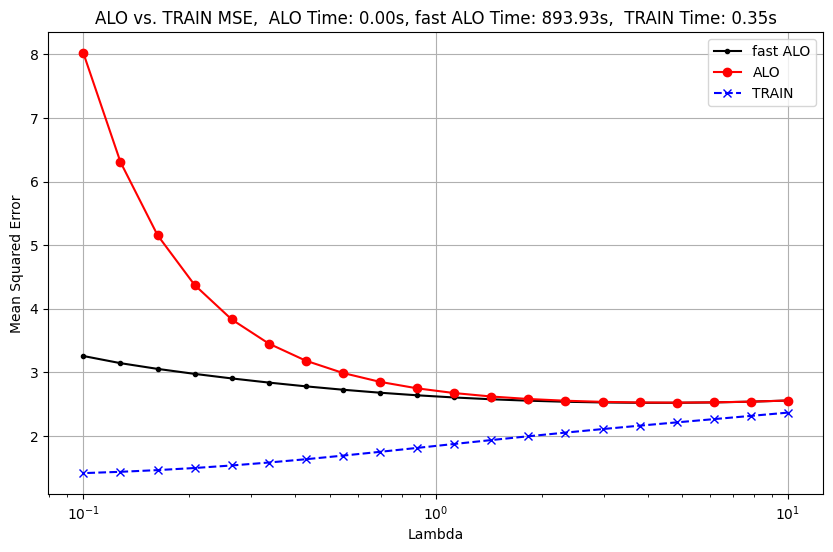

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the lists are numpy arrays for easier manipulation
timeALO_fast = np.array(timeALO_fast)  # Make sure to use the correct time list for ALO
timeALO = np.array(timeALO)  # Make sure to use the correct time list for ALO
timeTRAIN = np.array(timeTRAIN)
ALO = np.array(ALO)
ALO_fast = np.array(ALO_fast)
TRAIN = np.array(TRAIN)
lambdas = np.array(lambdas)


# Summing the computation times
total_time_ALO = np.sum(timeALO)
total_time_ALO_fast = np.sum(timeALO_fast)
total_time_TRAIN = np.sum(timeTRAIN)
print(total_time_ALO )
print(total_time_ALO_fast)

# Plotting ALO and TRAIN MSE against lambdas
plt.figure(figsize=(10, 6))
plt.plot(lambdas, ALO_fast, marker='.', linestyle='-', color='black', label='fast ALO')
plt.plot(lambdas, ALO, marker='o', linestyle='-', color='red', label='ALO')
plt.plot(lambdas, TRAIN, marker='x', linestyle='--', color='blue', label='TRAIN')
plt.xscale('log')  # Since lambda values are log-spaced
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title(f'ALO vs. TRAIN MSE,  ALO Time: {total_time_ALO:.2f}s, fast ALO Time: {total_time_ALO_fast:.2f}s,  TRAIN Time: {total_time_TRAIN:.2f}s')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

import matplotlib.pyplot as plt

# Plotting the fitting times against lambda values
plt.figure(figsize=(10, 6))
plt.plot(lambdas, fit_times, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Since lambda values are log-spaced
plt.xlabel('Lambda')
plt.ylabel('Fitting Time (seconds)')
plt.title(f'Fitting Time vs. Lambda, t={tt:.4f}')
plt.grid(True)
plt.show()